# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. In practice we'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

First up is importing the packages we'll need.

In [1]:
# Imports here

import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms

% matplotlib inline


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, I apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I also made sure that the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we will need to resize then crop the images to the appropriate size.

The pre-trained networks I use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets
data_transforms ={
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])
}

# Load the datasets with ImageFolder
image_datasets = { 'train' : datasets.ImageFolder(train_dir, transform= data_transforms['train']),
                   'valid' : datasets.ImageFolder(valid_dir, transform= data_transforms['valid']),
                   'test'  : datasets.ImageFolder(test_dir, transform= data_transforms['test'])}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = { 'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size= 64, shuffle=True),
                'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size= 32),
                'test'  : torch.utils.data.DataLoader(image_datasets['test'], batch_size= 32)
}


### Label mapping

We'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier.I use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

Steps:
* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

* try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model

In [5]:
# Build and train your network
# We use vgg19
model = models.vgg19(pretrained=True)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:16<00:00, 35593619.45it/s]


In [6]:
# We then build a new classifier, using ReLU activations
# We have 102 categories of flowers in our cat_to_name dictionary, so 102 outputs possible
# The input size is 25088 (due to the choice of vgg19 specifically)
# We will use the log_softmax for more precision

for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([ 
                        ('fc1', nn.Linear(25088,4096)), 
                        ('relu1', nn.ReLU()),
                        ('dropout1', nn.Dropout(0.2)), 
                        ('fc2', nn.Linear(4096,1024)), 
                        ('relu2', nn. ReLU()), 
                        ('dropout2', nn.Dropout(0.2)), 
                        ('fc3', nn.Linear(1024,102)), 
                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [7]:
# We write a function to train our network, which we can re-use easily changing the hyperparameters

def model_train(model, trainloader,validloader,learning_rate, epochs, print_every, criterion, optimizer):
    
   '''
    INPUT:
    model: a model instance we want to train
    criterion: the loss function 
    optimizer: which optimizer we want to use
    scheduler: the scheduler to adapt our learning rate
    epochs: the number of epochs
    print_every: We print every 'print_every' number of steps to have visibility somewhat regularly in our model

    OUTPUT:
    a trained model instance
    '''
    
    model.train()
    epochs = epochs
    print_every = print_every
    steps = 0

    # change to cuda
    model.to('cuda')

    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1

            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                validation_loss, validation_accuracy = check_accuracy_and_loss(model, criterion, validloader)
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Training Loss: {:.4f}".format(running_loss/print_every),
                      "Valiation Loss : {:.4f}".format(validation_loss),
                      "Validation Accuracy:{:.4f}".format(validation_accuracy))

                

In [8]:
def check_accuracy_and_loss(model, criterion, validloader):    
    # We put the network in evaluation mode, to turn off dropout
    # otherwise we will have particularly low accuracy
    
    model.eval()
    correct = 0
    total = 0
    valid_loss = 0
    with torch.no_grad():
        # Turn off gradients for validation
        
        for data in validloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_loss = criterion(outputs, labels).item()
            valid_accuracy = correct/total
        return valid_loss, valid_accuracy

         

In [9]:
# Number of epochs
epochs = 9


learning_rate = 0.001

# Criteria NLLLoss which is recommended
criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
model_train(model, dataloaders['train'],dataloaders['valid'], learning_rate, epochs, 40, criterion, optimizer)

Epoch: 1/9...  Training Loss: 3.9561 Valiation Loss : 3.2482 Validation Accuracy:0.4230
Epoch: 1/9...  Training Loss: 6.1327 Valiation Loss : 1.6215 Validation Accuracy:0.6247
Epoch: 2/9...  Training Loss: 0.6057 Valiation Loss : 1.0413 Validation Accuracy:0.7188
Epoch: 2/9...  Training Loss: 1.9093 Valiation Loss : 0.4849 Validation Accuracy:0.7641
Epoch: 2/9...  Training Loss: 3.0686 Valiation Loss : 0.4073 Validation Accuracy:0.7934
Epoch: 3/9...  Training Loss: 0.9116 Valiation Loss : 0.9411 Validation Accuracy:0.8032
Epoch: 3/9...  Training Loss: 1.9185 Valiation Loss : 0.5069 Validation Accuracy:0.7946
Epoch: 4/9...  Training Loss: 0.2406 Valiation Loss : 0.4885 Validation Accuracy:0.8313
Epoch: 4/9...  Training Loss: 1.0720 Valiation Loss : 0.9642 Validation Accuracy:0.8386
Epoch: 4/9...  Training Loss: 1.9474 Valiation Loss : 0.3264 Validation Accuracy:0.8411
Epoch: 5/9...  Training Loss: 0.5730 Valiation Loss : 0.2597 Validation Accuracy:0.8521
Epoch: 5/9...  Training Loss: 1.

## Testing your network

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. I run the test images through the network and measure the accuracy, the same way we did validation.

In [10]:
# validation on the test set

test_loss, accuracy = check_accuracy_and_loss(model, criterion, dataloaders['test'])
print("Accuracy:{:.4f}".format(accuracy))
print("test_loss:{:.4f}".format(test_loss))

Accuracy:0.8584
test_loss:1.7352


## Save the checkpoint

Now that our network is trained, I save the model so that we can load it later for making predictions. We can also save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`.We can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we'll want to completely rebuild the model later so we can use it for inference. We need to make sure to include any information we might need in the checkpoint. If we want to load the model and keep training, we'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. Since , we will want to use this trained model in the next part of the project, so best to save it now.

In [11]:
# Save the checkpoint
# We save the mapping of indices to class as an attribute to our model
# We also save the inverse mapping to be able to do everything we want

model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg19',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx},
            'classifier.pth')


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [12]:
# function that loads a checkpoint and rebuilds the model

def load_model(checkpoint_path):
    '''
    It takes a checkpoint and a model type (from Torchvision) and rebuilds the model
    '''
    # load our checkpoint, which contains information on the classifier which we need to build again
    # load our pre-trained model and freeze its parameters again
    
    
    chpt = torch.load(checkpoint_path)
    
    if chpt['arch'] == 'vgg19':
        model = models.vgg19(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture not recognized")
         
    
    model.class_to_idx = chpt['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model


# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. I write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

First we'll need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

We will use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [13]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

To check my work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [14]:
def imshow(image, ax=None, title=None):
    '''Imshow for Tensor'''
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once we get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor I use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which we added to the model or from an `ImageFolder` we used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [16]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    output = model.forward(model_input)
    probs = torch.exp(output)
    
    # Top probs
    top_probs, top_labs = probs.topk(topk)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    
    return top_probs, top_labels, top_flowers
    
    # plcode to predict the class from an image file

image_path = test_dir + '/27/image_06864.jpg'
probabilities, classes, flowers = predict(image_path, model)
print(probabilities)
print(classes)
print(flowers)

[0.9849675893783569, 0.012151204980909824, 0.00217213062569499, 0.00038700466393493116, 0.00010263447620673105]
['27', '61', '47', '24', '96']
['prince of wales feathers', 'cautleya spicata', 'marigold', 'red ginger', 'camellia']


## Sanity Checking

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Using `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file . To show a PyTorch tensor as an image,I use the `imshow` function defined above.

In [25]:
# Display an image along with the top 5 classes

def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

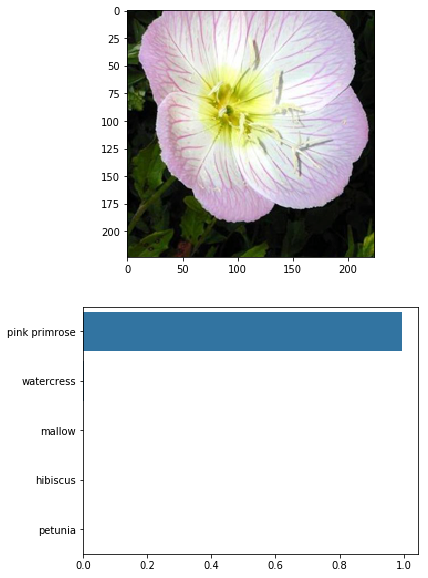

In [26]:
image_path = 'flowers/test/1/image_06743.jpg'
plot_solution(image_path, model)